   No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          2013.583333          13.3   
3   4          2013.500000          13.3   
4   5          2012.833333           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     24.98298     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47.3  
3     24.98746     121.54391  

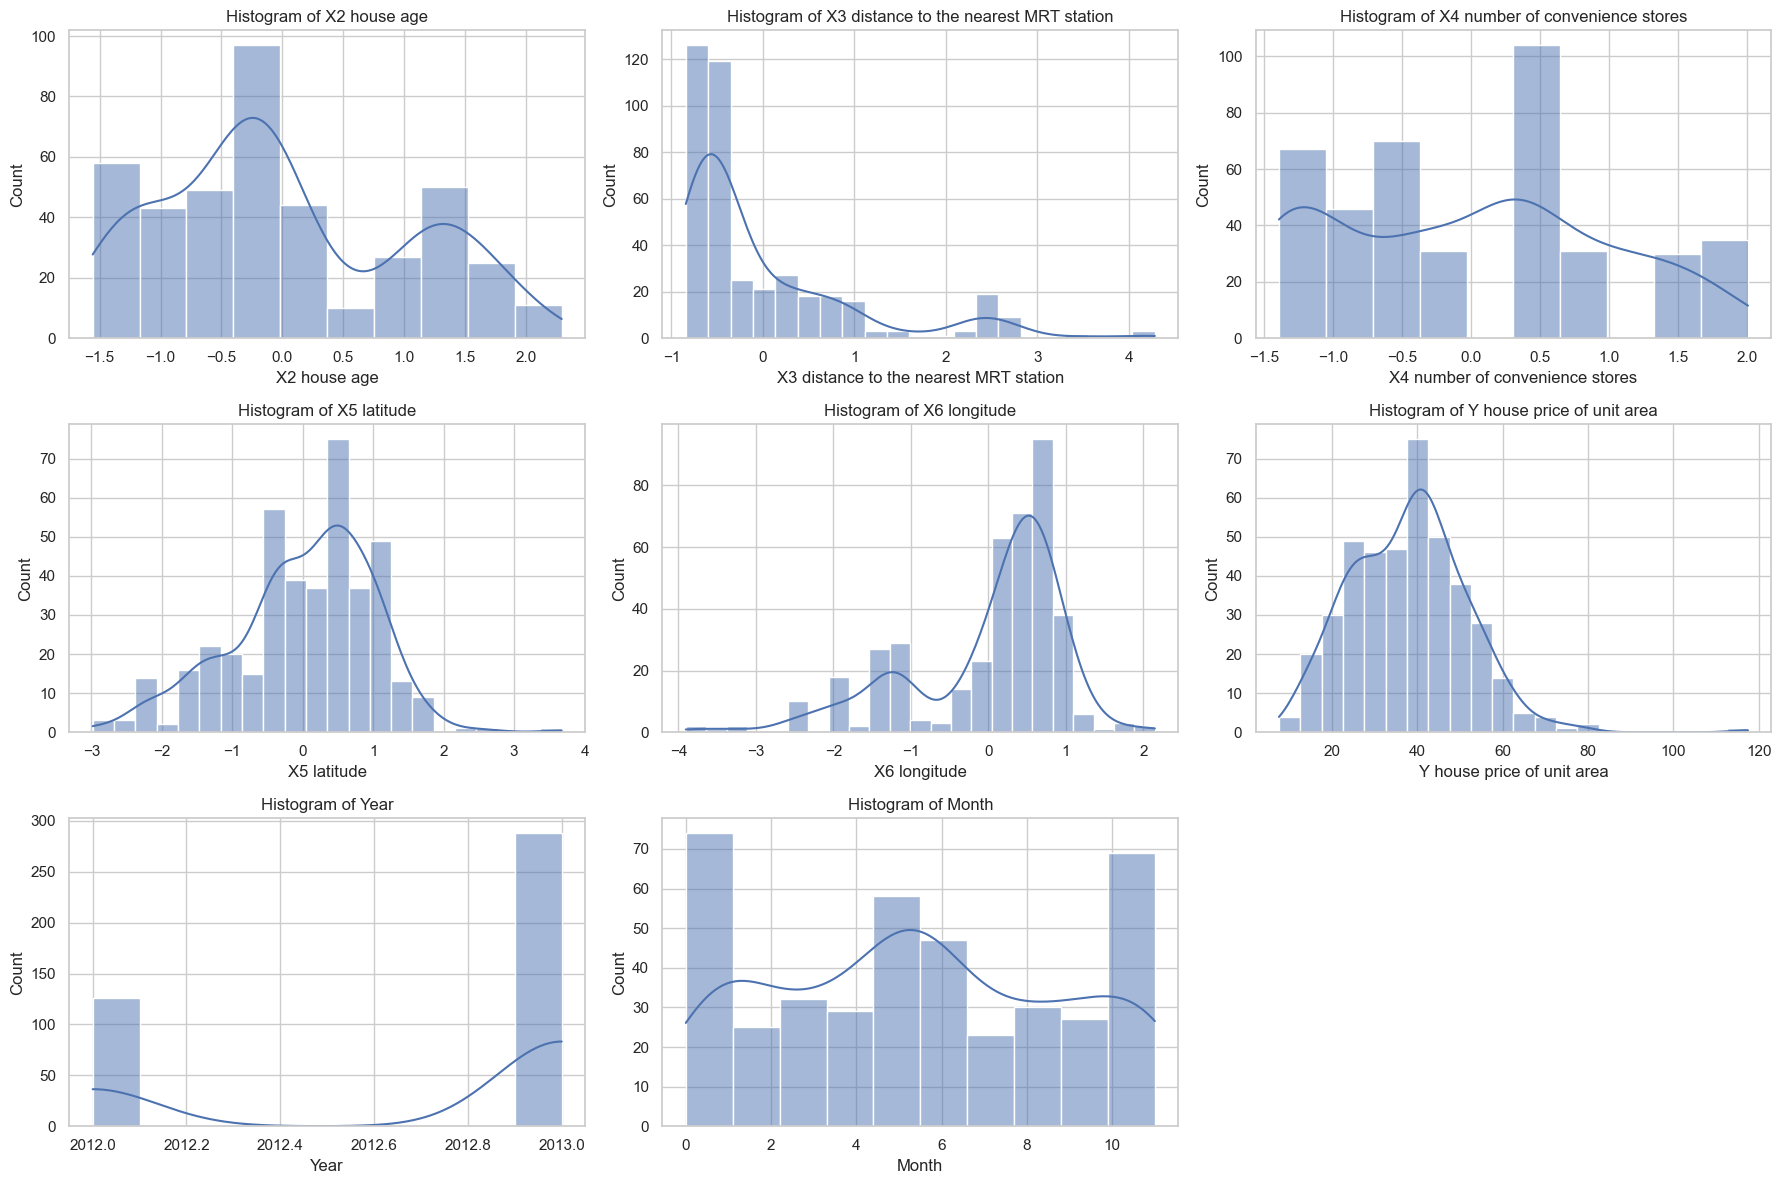

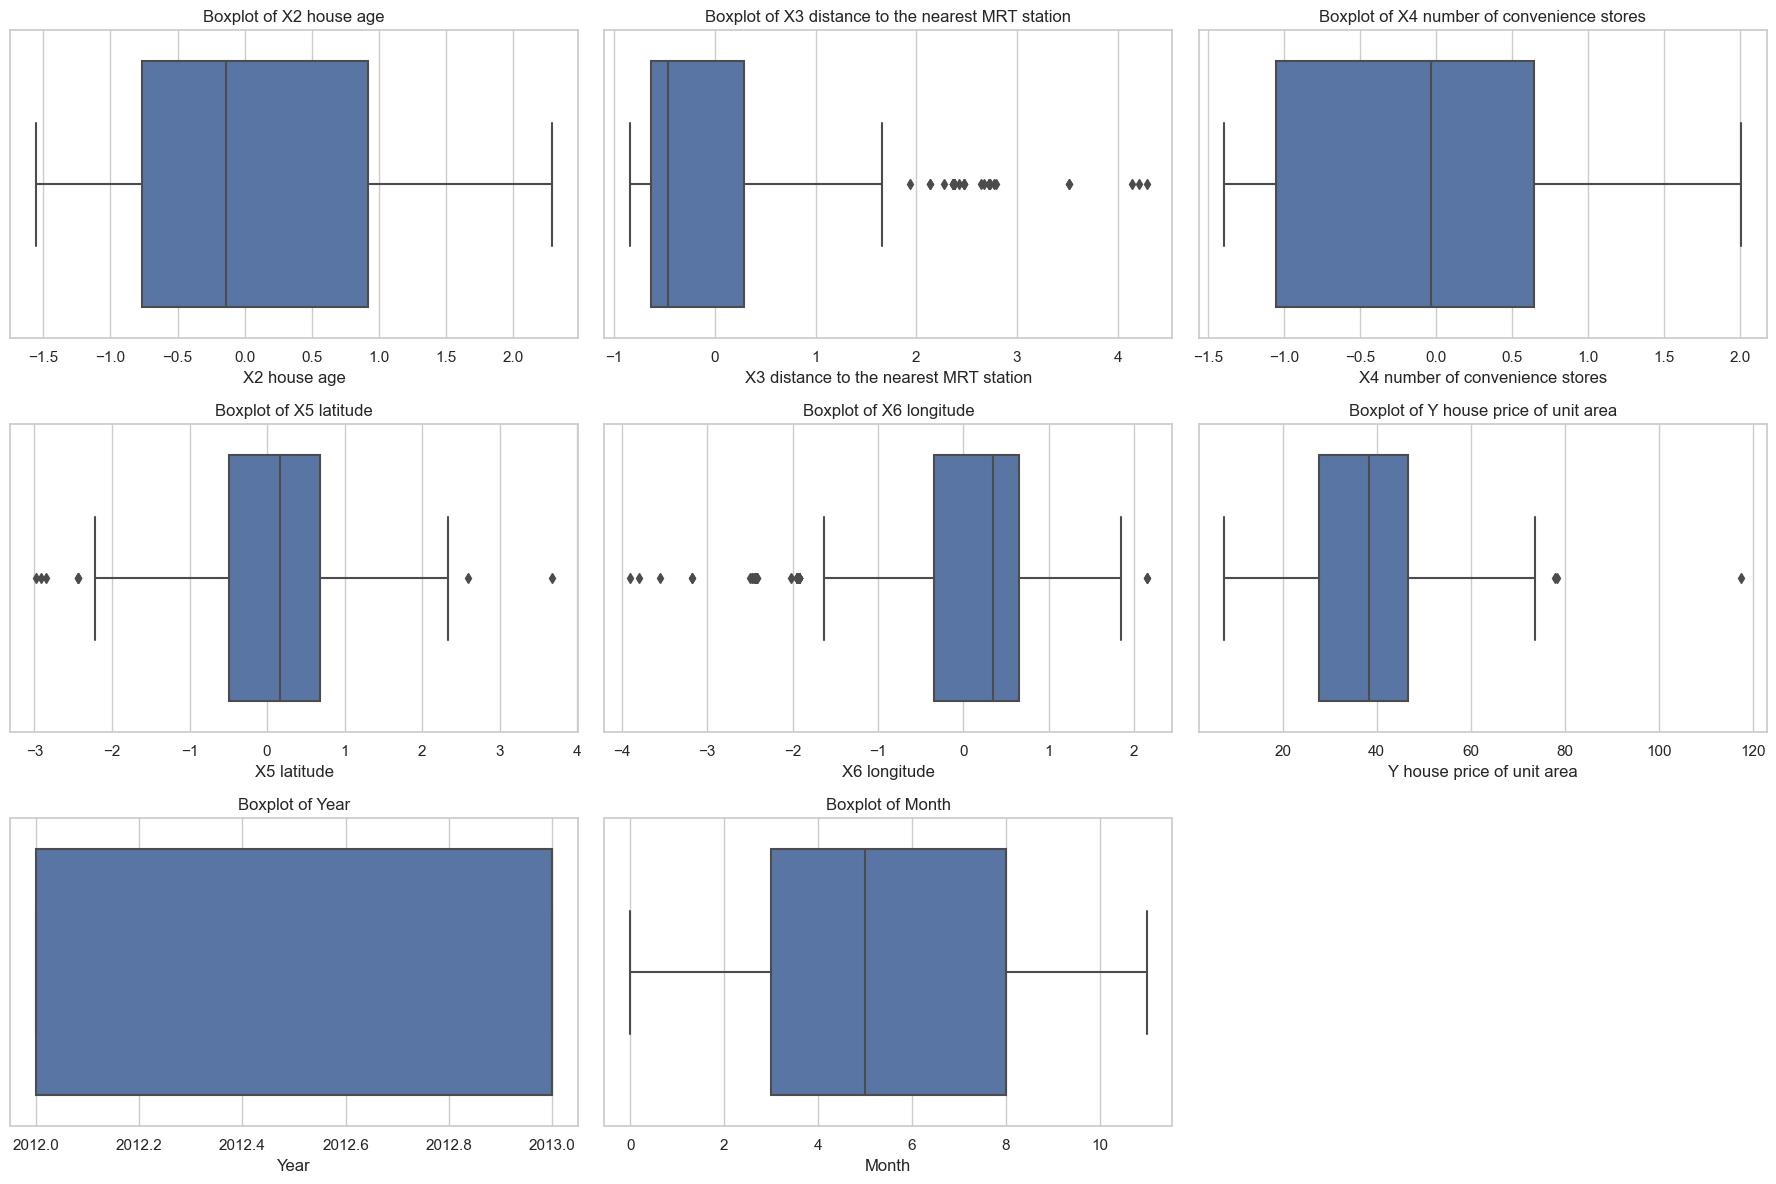

Outliers in Distance to MRT:
     X2 house age  X3 distance to the nearest MRT station  \
8        1.229263                                3.512777   
19      -1.424814                               -0.841279   
116      1.158957                                4.214234   
160     -1.249048                               -0.820433   
249      0.025261                                4.142735   
255      1.211687                                3.512777   
275     -1.424814                               -0.841279   
347     -0.027469                                4.287008   
377     -1.213894                               -0.820433   

     X4 number of convenience stores  X5 latitude  X6 longitude  \
8                          -1.051734    -1.458635     -3.182350   
19                          0.987694    -0.105692      0.499647   
116                        -1.051734    -2.039505     -3.557465   
160                         1.327598    -0.860823      0.273926   
249                      

In [2]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'Real estate valuation data set.xlsx'
data = pd.read_excel(file_path, sheet_name=0)

# Display the first few rows of the dataset to understand its structure
print(data.head())

# Check data types and non-null counts
print(data.info())

# Data preprocess

# Convert the transaction date to year and month
data['Year'] = data['X1 transaction date'].apply(lambda x: int(x))
data['Month'] = data['X1 transaction date'].apply(lambda x: int(round((x - int(x)) * 12)))

# Drop the 'No' and 'X1 transaction date' columns
data = data.drop(columns=['No', 'X1 transaction date'])

# Display the updated DataFrame to verify changes
print(data.head())

# Feature scaling

# Create the scaler object
scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']

# Apply the scaler to the dataset
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Display the scaled data
print(data.head())

# EDA

# Generate the statistical summary of the dataset
statistical_summary = data.describe()

# Display the statistical summary
print(statistical_summary)

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Create a figure for the histograms
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# List of all columns for histogram
hist_columns = ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores',
                'X5 latitude', 'X6 longitude', 'Y house price of unit area', 'Year', 'Month']

# Plot histograms
for ax, column in zip(axs.flat, hist_columns):
    sns.histplot(data[column], kde=True, ax=ax)
    ax.set_title(f'Histogram of {column}')
    
# Remove the last empty subplot
fig.delaxes(axs[2, 2])

# Adjust layout
plt.tight_layout()

# Show the histograms
plt.show()

# Create boxplots to identify outliers
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Plot boxplots
for ax, column in zip(axs.flat, hist_columns):
    sns.boxplot(x=data[column], ax=ax)
    ax.set_title(f'Boxplot of {column}')

# Remove the last empty subplot
fig.delaxes(axs[2, 2])

# Adjust layout
plt.tight_layout()

# Show the boxplots
plt.show()

# Identify outliers

# Determine the 0.01 and 0.99 quantiles for the selected columns
quantiles = data[['X3 distance to the nearest MRT station', 'Y house price of unit area']].quantile([0.01, 0.99])

# Identify outliers
outliers_distance = data[(data['X3 distance to the nearest MRT station'] < quantiles.loc[0.01, 'X3 distance to the nearest MRT station']) | 
                         (data['X3 distance to the nearest MRT station'] > quantiles.loc[0.99, 'X3 distance to the nearest MRT station'])]

outliers_price = data[(data['Y house price of unit area'] < quantiles.loc[0.01, 'Y house price of unit area']) | 
                      (data['Y house price of unit area'] > quantiles.loc[0.99, 'Y house price of unit area'])]

# Display the outliers
print("Outliers in Distance to MRT:")
print(outliers_distance)
print("\nOutliers in House Price:")
print(outliers_price)

# Handle outliers

# Apply capping and flooring to the dataset
data['X3 distance to the nearest MRT station'] = data['X3 distance to the nearest MRT station'].clip(lower=quantiles.loc[0.01, 'X3 distance to the nearest MRT station'], upper=quantiles.loc[0.99, 'X3 distance to the nearest MRT station'])
data['Y house price of unit area'] = data['Y house price of unit area'].clip(lower=quantiles.loc[0.01, 'Y house price of unit area'], upper=quantiles.loc[0.99, 'Y house price of unit area'])

# Verify changes by displaying the updated statistical summary for these columns
updated_quantiles = data[['X3 distance to the nearest MRT station', 'Y house price of unit area']].quantile([0.01, 0.99])
print(updated_quantiles)

# Feature engineering

# Square the specified columns
data['X2 house age^2'] = data['X2 house age'] ** 2
data['X3 distance to MRT^2'] = data['X3 distance to the nearest MRT station'] ** 2
data['X4 number of stores^2'] = data['X4 number of convenience stores'] ** 2

# Create interaction terms
data['Age * Distance to MRT'] = data['X2 house age'] * data['X3 distance to the nearest MRT station']
data['Age * Number of Stores'] = data['X2 house age'] * data['X4 number of convenience stores']
data['Stores * Distance to MRT'] = data['X4 number of convenience stores'] * data['X3 distance to the nearest MRT station']

# Display the updated DataFrame to verify changes
new_feature_head = data.head()
print(new_feature_head)

# Combine latitude and longitude into a single column as tuples
data['Coordinates'] = list(zip(data['X5 latitude'], data['X6 longitude']))

# Display the updated DataFrame to verify changes
print(data[['X5 latitude', 'X6 longitude', 'Coordinates']].head())


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming 'data' has been preprocessed and features engineered as previously described
# Define the features and target variable, exclude 'Coordinates'
X = data.drop(['Y house price of unit area', 'Coordinates'], axis=1)
y = data['Y house price of unit area']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

# Dictionary to hold performance metrics for each model
performance_metrics = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Store metrics
    performance_metrics[model_name] = {'R2': r2, 'MSE': mse, 'RMSE': rmse}

print(performance_metrics)

# Cross-validation check

# Define the number of folds for cross-validation
cv_folds = 5

# Perform cross-validation
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv_folds, scoring='r2')
    cv_results[model_name] = {
        'CV Mean R2': np.mean(scores),
        'CV Std R2': np.std(scores)
    }

print(cv_results)

# Parameter tuning

# Corrected parameter grids
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.9, 1.0]
}

# Set up GridSearchCV
grid_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid_gb, cv=3, scoring='r2', n_jobs=-1)

# Run grid search
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

# Best parameters and best score
best_params_rf = grid_rf.best_params_
best_score_rf = grid_rf.best_score_
best_params_gb = grid_gb.best_params_
best_score_gb = grid_gb.best_score_

(best_params_rf, best_score_rf, best_params_gb, best_score_gb)


{'LinearRegression': {'R2': 0.7697516134323661, 'MSE': 38.330823584020195, 'RMSE': 6.191189189809999}, 'Ridge': {'R2': 0.7713081757439891, 'MSE': 38.071693362724034, 'RMSE': 6.170226362356898}, 'Lasso': {'R2': 0.7005925493531244, 'MSE': 49.844145887708386, 'RMSE': 7.0600386604967245}, 'RandomForestRegressor': {'R2': 0.8278780019198619, 'MSE': 28.654176655439205, 'RMSE': 5.352959616458843}, 'GradientBoostingRegressor': {'R2': 0.8333679704349818, 'MSE': 27.7402288194874, 'RMSE': 5.266899355359603}}
{'LinearRegression': {'CV Mean R2': 0.7177593152055148, 'CV Std R2': 0.057514717877793}, 'Ridge': {'CV Mean R2': 0.7179488551098941, 'CV Std R2': 0.05845693561634313}, 'Lasso': {'CV Mean R2': 0.6329492590420178, 'CV Std R2': 0.05564619348499433}, 'RandomForestRegressor': {'CV Mean R2': 0.7542332348243491, 'CV Std R2': 0.03816908669204003}, 'GradientBoostingRegressor': {'CV Mean R2': 0.7683625047742162, 'CV Std R2': 0.03885270278449268}}


({'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_split': 2,
  'n_estimators': 200},
 0.7519064332194793,
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0},
 0.7506376187555658)

0.8327752117058347 0.8331345723332677
(0.8932679994796856, 0.8327752117058347) (0.9420764071076613, 0.8331345723332677)


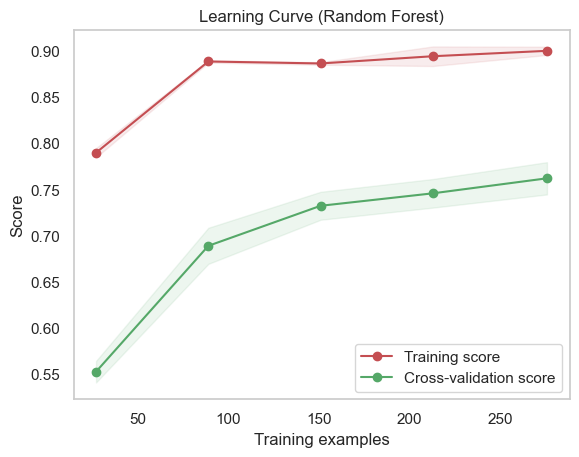

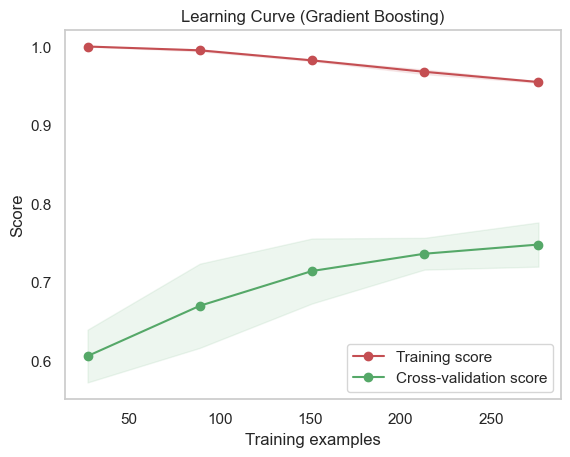

In [8]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' has been preprocessed and features engineered as previously described
# Define the features and target variable, exclude 'Coordinates'
X = data.drop(['Y house price of unit area', 'Coordinates'], axis=1)
y = data['Y house price of unit area']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-instantiate the models with the optimal parameters
optimal_rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=10, min_samples_split=10)
optimal_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0)

# Train the models on the entire training dataset
optimal_rf.fit(X_train, y_train)
optimal_gb.fit(X_train, y_train)

# Predict using the test dataset
rf_predictions = optimal_rf.predict(X_test)
gb_predictions = optimal_gb.predict(X_test)

# Evaluate the models
rf_r2 = r2_score(y_test, rf_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

print(rf_r2, gb_r2)

# Check for overfitting

# Calculate performance on the training set
rf_train_predictions = optimal_rf.predict(X_train)
gb_train_predictions = optimal_gb.predict(X_train)

rf_train_r2 = r2_score(y_train, rf_train_predictions)
gb_train_r2 = r2_score(y_train, gb_train_predictions)
rf_test_r2 = r2_score(y_test, rf_predictions)
gb_test_r2 = r2_score(y_test, gb_predictions)

# Display training and testing performance
print((rf_train_r2, rf_test_r2), (gb_train_r2, gb_test_r2))

# Learning curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for RandomForest
plot_learning_curve(optimal_rf, "Learning Curve (Random Forest)", X, y, cv=3)
plt.show()

# Plot learning curve for GradientBoosting
plot_learning_curve(optimal_gb, "Learning Curve (Gradient Boosting)", X, y, cv=3)
plt.show()


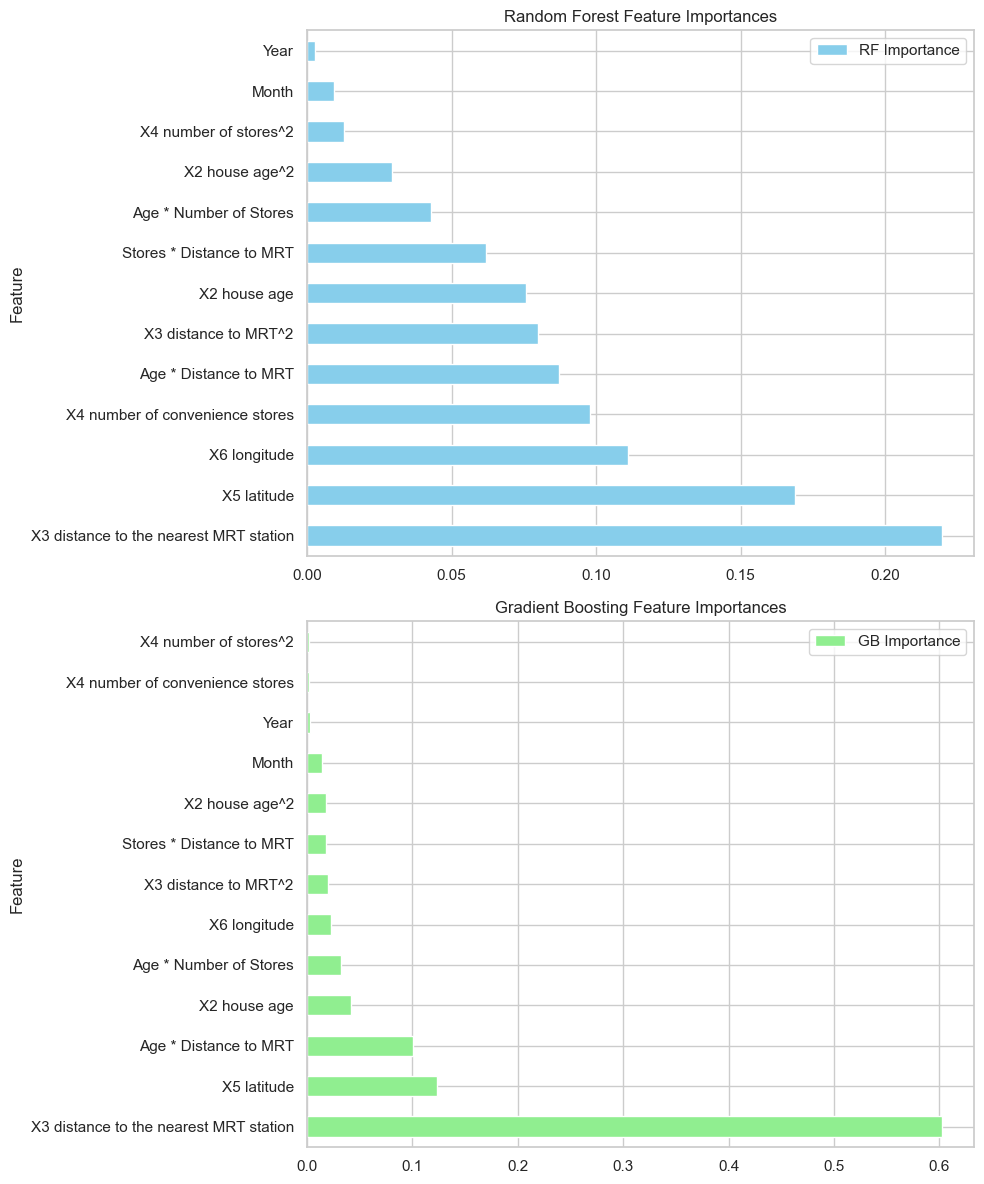

Random Forest Reduced - R^2: 0.8331940760516762 MSE: 27.769178055693143 RMSE: 5.2696468625224915
Gradient Boosting Reduced - R^2: 0.8233135972686892 MSE: 29.41404034898473 RMSE: 5.423471245335844
Best Random Forest Params: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10} with R^2: 0.7215714276219395
Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8} with R^2: 0.7359661750815972
Random Forest - Mean R^2: 0.7198510646181452 , Standard Deviation: 0.047694152215692016
Gradient Boosting - Mean R^2: 0.7249207438769188 , Standard Deviation: 0.05327515521093125


In [5]:
# Feature selection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

# Assuming 'data', 'X_train', 'X_test', 'y_train', 'y_test' have been defined as described in previous steps

# Re-instantiate the models with the optimal parameters
optimal_rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=10, min_samples_split=10)
optimal_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0)

# Fit the models
optimal_rf.fit(X_train, y_train)
optimal_gb.fit(X_train, y_train)

# Get feature importances
rf_importances = optimal_rf.feature_importances_
gb_importances = optimal_gb.feature_importances_

# Summarize feature importances
features = X_train.columns
importances = pd.DataFrame({
    'Feature': features,
    'RF Importance': rf_importances,
    'GB Importance': gb_importances
})

# Plot feature importances for better visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
importances.sort_values('RF Importance', ascending=False).plot(x='Feature', y='RF Importance', kind='barh', color='skyblue', ax=axs[0], title='Random Forest Feature Importances')
importances.sort_values('GB Importance', ascending=False).plot(x='Feature', y='GB Importance', kind='barh', color='lightgreen', ax=axs[1], title='Gradient Boosting Feature Importances')
plt.tight_layout()
plt.show()

# Consider removing features with very low importance
threshold = 0.01  # set threshold
features_to_keep = importances[(importances['RF Importance'] > threshold) & (importances['GB Importance'] > threshold)]['Feature']

# Reduce the dataset
X_train_reduced = X_train[features_to_keep]
X_test_reduced = X_test[features_to_keep]

# Train on reduced feature set

# Instantiate the models with optimal parameters
optimal_rf_reduced = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=10, min_samples_split=10)
optimal_gb_reduced = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0)

# Train the models on the reduced feature set
optimal_rf_reduced.fit(X_train_reduced, y_train)
optimal_gb_reduced.fit(X_train_reduced, y_train)

# Predict on the test set using the reduced feature set
rf_predictions_reduced = optimal_rf_reduced.predict(X_test_reduced)
gb_predictions_reduced = optimal_gb_reduced.predict(X_test_reduced)

# Calculate and print performance metrics
rf_r2_reduced = r2_score(y_test, rf_predictions_reduced)
gb_r2_reduced = r2_score(y_test, gb_predictions_reduced)

rf_mse_reduced = mean_squared_error(y_test, rf_predictions_reduced)
gb_mse_reduced = mean_squared_error(y_test, gb_predictions_reduced)

rf_rmse_reduced = np.sqrt(rf_mse_reduced)
gb_rmse_reduced = np.sqrt(gb_mse_reduced)

print("Random Forest Reduced - R^2:", rf_r2_reduced, "MSE:", rf_mse_reduced, "RMSE:", rf_rmse_reduced)
print("Gradient Boosting Reduced - R^2:", gb_r2_reduced, "MSE:", gb_mse_reduced, "RMSE:", gb_rmse_reduced)

# Tune parameters on unreduced feature set

# Parameter grid for Random Forest
param_grid_rf = {
    'min_samples_split': [10, 15, 20],  # Increased values
    'min_samples_leaf': [4, 6, 8],
    'max_depth': [10, 15, 20]  # Reduced values
}

# Parameter grid for Gradient Boosting
param_grid_gb = {
    'learning_rate': [0.05, 0.075, 0.1],  # Decreased values
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9]  # Slightly reduced values
}

# Setup GridSearchCV
grid_rf = GridSearchCV(estimator=RandomForestRegressor(n_estimators=200), param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_gb = GridSearchCV(estimator=GradientBoostingRegressor(n_estimators=100), param_grid=param_grid_gb, cv=5, scoring='r2', n_jobs=-1)

# Fit Grid Search
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

# Best parameters and scores
best_params_rf = grid_rf.best_params_
best_params_gb = grid_gb.best_params_
best_score_rf = grid_rf.best_score_
best_score_gb = grid_gb.best_score_

print("Best Random Forest Params:", best_params_rf, "with R^2:", best_score_rf)
print("Best Gradient Boosting Params:", best_params_gb, "with R^2:", best_score_gb)

# Cross-validation check on reduced feature and tuned parameter set

# Set up the models with the parameters from feature selection and regularization tuning
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=4, min_samples_split=15)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8)

# Perform cross-validation
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
gb_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='r2')

# Calculate mean and standard deviation of scores
rf_mean = np.mean(rf_scores)
rf_std = np.std(rf_scores)
gb_mean = np.mean(gb_scores)
gb_std = np.std(gb_scores)

print("Random Forest - Mean R^2:", rf_mean, ", Standard Deviation:", rf_std)
print("Gradient Boosting - Mean R^2:", gb_mean, ", Standard Deviation:", gb_std)


In [6]:
# Test RF and GB

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming you have already split your data into X_train, X_test, y_train, y_test

# Initialize the models
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()

# Fit the models on the training data
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predict on the test set
rf_test_predictions = rf_model.predict(X_test)
gb_test_predictions = gb_model.predict(X_test)

# Calculate performance metrics
rf_test_r2 = r2_score(y_test, rf_test_predictions)
gb_test_r2 = r2_score(y_test, gb_test_predictions)
rf_test_mse = mean_squared_error(y_test, rf_test_predictions)
gb_test_mse = mean_squared_error(y_test, gb_test_predictions)
rf_test_rmse = np.sqrt(rf_test_mse)
gb_test_rmse = np.sqrt(gb_test_mse)

# Print the results
print("Random Forest - Test R^2:", rf_test_r2, "MSE:", rf_test_mse, "RMSE:", rf_test_rmse)
print("Gradient Boosting - Test R^2:", gb_test_r2, "MSE:", gb_test_mse, "RMSE:", gb_test_rmse)

# Ensemble RF and GB

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define the stacking ensemble
estimators = [
    ('random_forest', optimal_rf),
    ('gradient_boosting', optimal_gb)
]
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)

# Fit the stacking model
stacking_regressor.fit(X_train, y_train)

# Predict and evaluate
stacked_predictions = stacking_regressor.predict(X_test)
stacked_r2 = r2_score(y_test, stacked_predictions)
stacked_mse = mean_squared_error(y_test, stacked_predictions)
stacked_rmse = np.sqrt(stacked_mse)

print("Stacking Ensemble - Test R^2:", stacked_r2, "MSE:", stacked_mse, "RMSE:", stacked_rmse)


Random Forest - Test R^2: 0.8360102067553258 MSE: 27.300359964064832 RMSE: 5.224974637647998
Gradient Boosting - Test R^2: 0.8349505132653849 MSE: 27.476773466116136 RMSE: 5.241829209933889
Stacking Ensemble - Test R^2: 0.8431105433606915 MSE: 26.118324537608167 RMSE: 5.110609018268582
